# 11장. 시퀀스 모델을 위한 합성곱 신경망과 순환 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch11/11-sequence-model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

## 시퀀스 데이터를 위한 합성곱

### 1D 합성곱 신경망 만들기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """임의로 정한 패턴이므로 바꿔도 좋습니다"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """기간마다 동일한 패턴을 반복합니다"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# 시계열을 만듭니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# 잡음을 추가합니다.
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

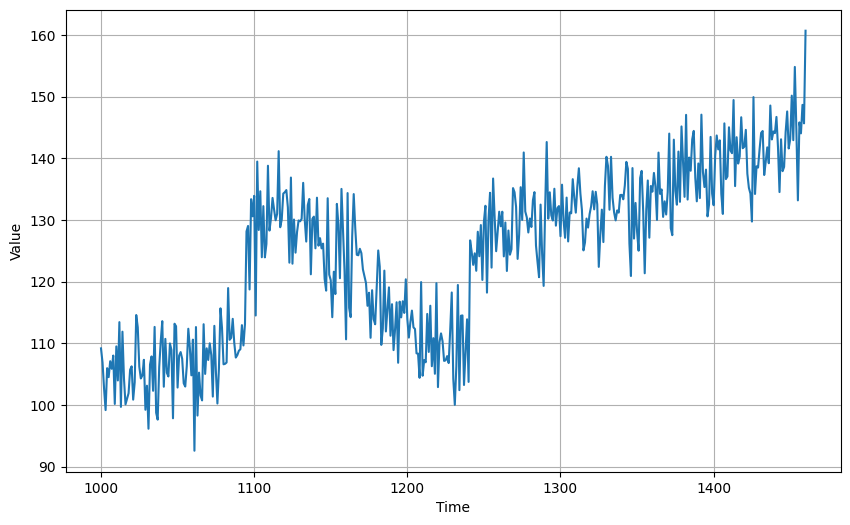

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=2, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

2023-01-06 10:19:54.392840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 10:19:54.560485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 10:19:54.562312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 10:19:54.566818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2023-01-06 10:20:00.152242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


31/31 [==============================] - 12s 13ms/step - loss: 4250.7817
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 4234.7822
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 4215.1089
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 4194.7378
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 4173.3452
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 4150.4927
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 4125.5928
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 4097.8926
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 4066.4448
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 4030.0854
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 3987.2708
Epoch 12/100
31/31 [==============================] - 0s 4ms/step - loss: 3935.8455
Epoch 13/10

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 0s 5ms/step


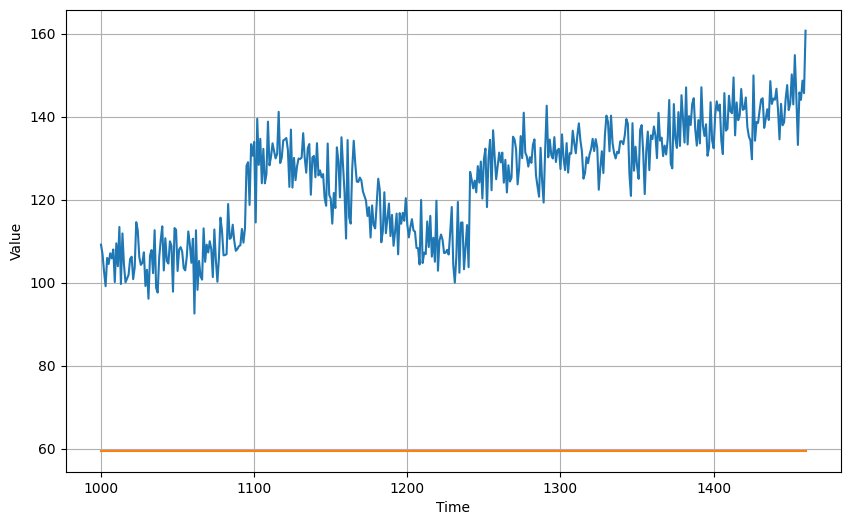

In [8]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

64.899025

### Conv1D 하이퍼파라미터 튜닝

In [10]:
!pip install keras_tuner

  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.8.0
    Uninstalling google-auth-oauthlib-0.8.0:
      Successfully uninstalled google-auth-oauthlib-0.8.0
  Rolling back uninstall of google-auth-oauthlib
  Moving to /opt/conda/bin/google-oauthlib-tool
   from /tmp/pip-uninstall-sjpq3ivv/google-oauthlib-tool
  Moving to /opt/conda/lib/python3.7/site-packages/google_auth_oauthlib-0.8.0.dist-info/
   from /opt/conda/lib/python3.7/site-packages/~oogle_auth_oauthlib-0.8.0.dist-info
  Moving to /opt/conda/lib/python3.7/site-packages/google_auth_oauthlib/
   from /opt/conda/lib/python3.7/site-packages/~oogle_auth_oauthlib
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/lib/python3.7/site-packages/google_auth_oauthlib-0.4.6.dist-info/LICENSE'
Consider using the `--user` option or check the permissions.



In [11]:
from keras_tuner.tuners import RandomSearch

In [12]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                     kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                     strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                     padding='causal', activation='relu', input_shape=[None, 1]))

    model.add(tf.keras.layers.Dense(28, input_shape=[window_size], activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    sgd = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=1e-5)
    model.compile(loss="mse", optimizer=sgd)
    return model

tuner = RandomSearch(build_model, objective='loss', max_trials=500, 
                     executions_per_trial=3, directory='my_dir', project_name='cnn-tune')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=2)

Trial 13 Complete [00h 00m 59s]
loss: 62.32146962483724

Best loss So Far: 61.5276133219401
Total elapsed time: 00h 13m 08s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

Results summary
Results in my_dir/cnn-tune
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 1
Score: 61.5276133219401
Trial summary
Hyperparameters:
units: 256
kernels: 6
strides: 2
Score: 61.56829833984375
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
Score: 61.65466054280599
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 2
Score: 61.79093551635742
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 2
Score: 61.829779307047524
Trial summary
Hyperparameters:
units: 256
kernels: 9
strides: 3
Score: 62.32146962483724
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 3
Score: 62.359762827555336
Trial summary
Hyperparameters:
units: 192
kernels: 6
strides: 3
Score: 62.435919443766274
Trial summary
Hyperparameters:
units: 128
kernels: 6
strides: 3
Score: 62.539040883382164
Trial summary
Hyperparameters:
units: 192
kernels: 3
strides: 2
Score: 63.38300323486328


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]

In [15]:
forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

46/46 [==============================] - 0s 4ms/step


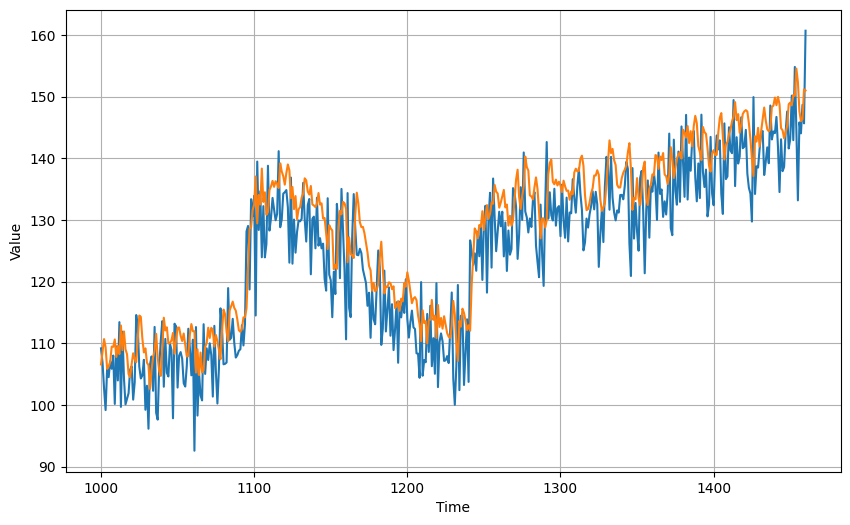

In [16]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.8556476

## NASA 날씨 데이터 사용하기

### 파이썬으로 GISS 데이터 읽기

In [18]:
!wget https://storage.googleapis.com/learning-datasets/station.csv

--2023-01-06 10:33:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘station.csv’

station.csv         100%[===================>]   6.82K  --.-KB/s    in 0s      

2023-01-06 10:33:44 (69.6 MB/s) - ‘station.csv’ saved [6979/6979]



In [19]:
def get_station_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))
    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [20]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [21]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [22]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

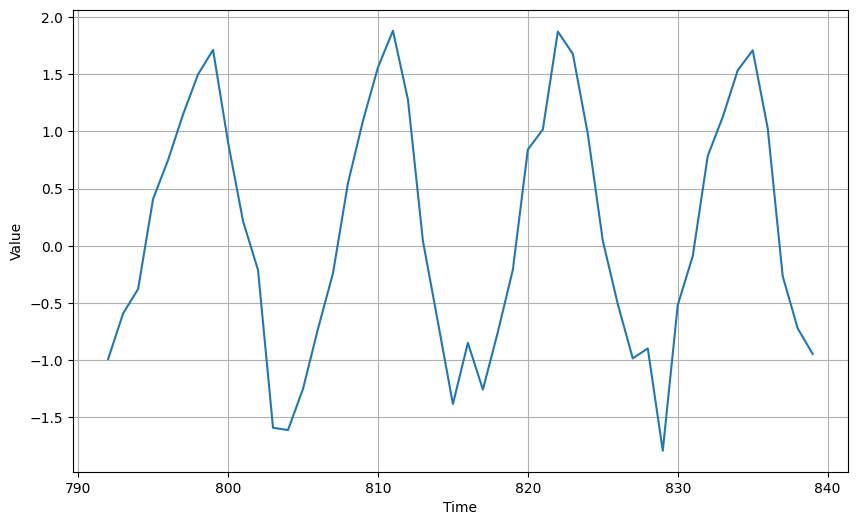

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [24]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

## RNN으로 시퀀스 모델링하기

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, 
                              input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(100),
    tf.keras.layers.Dense(1)
])

In [26]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1,
                    validation_data=valid_dataset)

Epoch 1/100
64/64 [==============================] - 3s 37ms/step - loss: 0.1528 - mae: 0.4457 - val_loss: 0.1481 - val_mae: 0.4412
Epoch 2/100
64/64 [==============================] - 2s 32ms/step - loss: 0.1383 - mae: 0.4218 - val_loss: 0.1322 - val_mae: 0.4135
Epoch 3/100
64/64 [==============================] - 2s 32ms/step - loss: 0.1260 - mae: 0.4006 - val_loss: 0.1190 - val_mae: 0.3887
Epoch 4/100
64/64 [==============================] - 2s 32ms/step - loss: 0.1158 - mae: 0.3826 - val_loss: 0.1079 - val_mae: 0.3662
Epoch 5/100
64/64 [==============================] - 2s 32ms/step - loss: 0.1075 - mae: 0.3674 - val_loss: 0.0987 - val_mae: 0.3465
Epoch 6/100
64/64 [==============================] - 2s 32ms/step - loss: 0.1005 - mae: 0.3547 - val_loss: 0.0911 - val_mae: 0.3320
Epoch 7/100
64/64 [==============================] - 2s 32ms/step - loss: 0.0948 - mae: 0.3438 - val_loss: 0.0846 - val_mae: 0.3193
Epoch 8/100
64/64 [==============================] - 2s 36ms/step - loss: 0.

In [27]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 0s 32ms/step


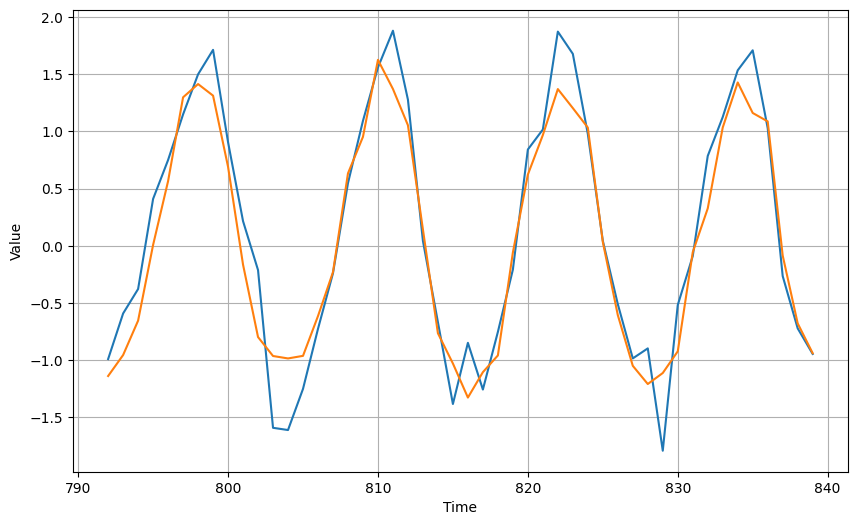

In [29]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.24592747

### 대용량 데이터셋 사용하기

In [31]:
!wget https://storage.googleapis.com/learning-datasets/tdaily_cet.dat.txt

--2023-01-06 10:37:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/tdaily_cet.dat.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1728976 (1.6M) [text/plain]
Saving to: ‘tdaily_cet.dat.txt’

tdaily_cet.dat.txt  100%[===================>]   1.65M  --.-KB/s    in 0.009s  

2023-01-06 10:37:16 (184 MB/s) - ‘tdaily_cet.dat.txt’ saved [1728976/1728976]



In [32]:
def get_tdaily_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [33]:
time, series = get_tdaily_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

split_time = 80000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [34]:
window_size = 60
batch_size = 120
shuffle_buffer_size = 240

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.SimpleRNN(100), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
667/667 [==============================] - 57s 83ms/step - loss: 0.1736 - mae: 0.4675 - val_loss: 0.1069 - val_mae: 0.3680
Epoch 2/100
667/667 [==============================] - 56s 84ms/step - loss: 0.0999 - mae: 0.3532 - val_loss: 0.0826 - val_mae: 0.3232
Epoch 3/100
667/667 [==============================] - 55s 83ms/step - loss: 0.0845 - mae: 0.3241 - val_loss: 0.0728 - val_mae: 0.3030
Epoch 4/100
667/667 [==============================] - 55s 83ms/step - loss: 0.0771 - mae: 0.3092 - val_loss: 0.0672 - val_mae: 0.2908
Epoch 5/100
667/667 [==============================] - 56s 83ms/step - loss: 0.0725 - mae: 0.2995 - val_loss: 0.0634 - val_mae: 0.2825
Epoch 6/100
667/667 [==============================] - 55s 83ms/step - loss: 0.0693 - mae: 0.2925 - val_loss: 0.0607 - val_mae: 0.2763
Epoch 7/100
667/667 [==============================] - 55s 83ms/step - loss: 0.0669 - mae: 0.2872 - val_loss: 0.0586 - val_mae: 0.2714
Epoch 8/100
667/667 [==============================] - 

In [35]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

334/334 [==============================] - 4s 11ms/step


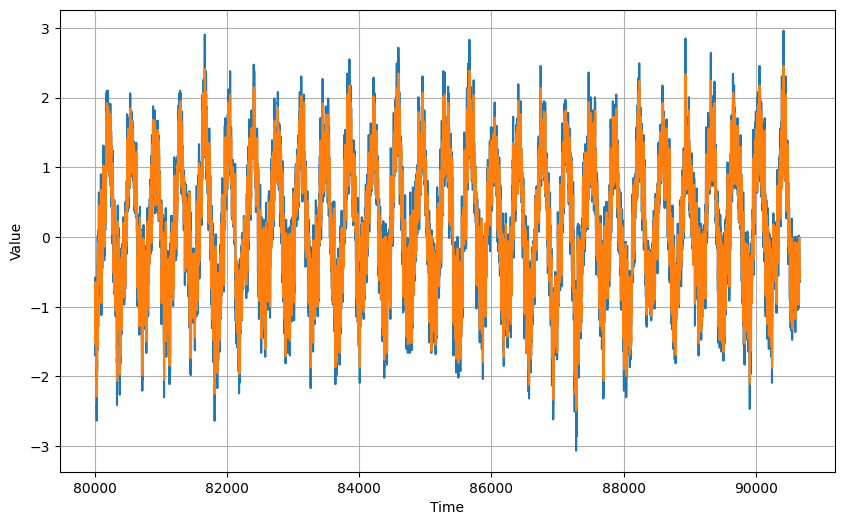

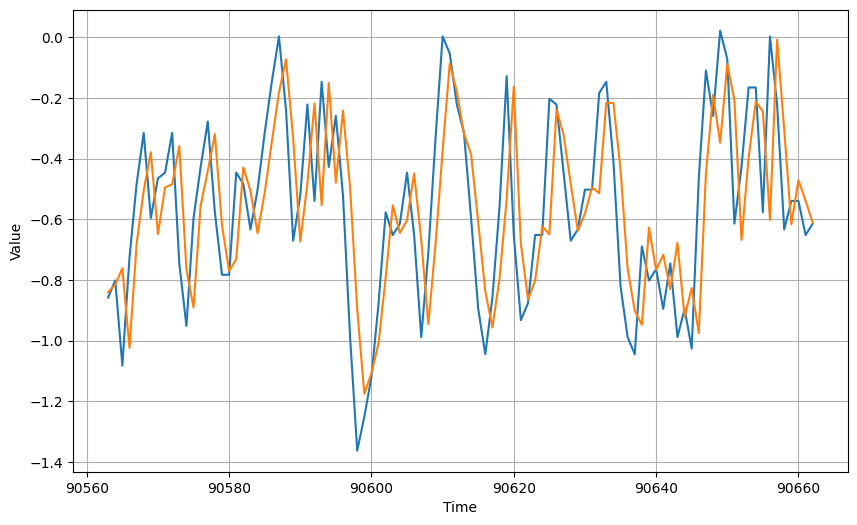

In [36]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2418286

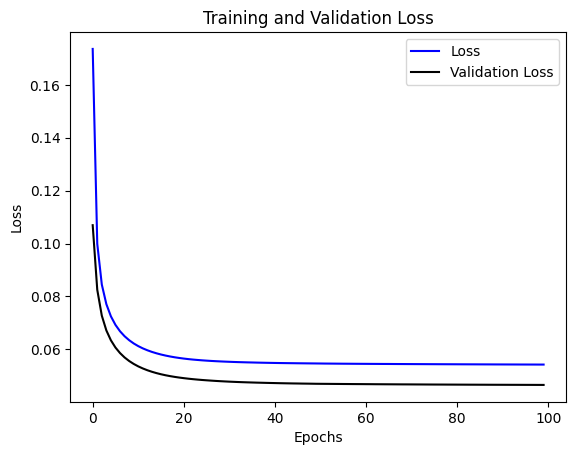

In [38]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## Dropout 사용하기

In [39]:
time, series = get_station_data()
mean = series.mean(axis=0)
series -= mean
std = series.std(axis=0)
series /= std

In [40]:
split_time = 792
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [41]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, 
                        dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 12s 136ms/step - loss: 0.4376 - mae: 0.8454 - val_loss: 0.4886 - val_mae: 0.9072
Epoch 2/500
64/64 [==============================] - 8s 130ms/step - loss: 0.4357 - mae: 0.8435 - val_loss: 0.4871 - val_mae: 0.9050
Epoch 3/500
64/64 [==============================] - 8s 130ms/step - loss: 0.4339 - mae: 0.8409 - val_loss: 0.4855 - val_mae: 0.9029
Epoch 4/500
64/64 [==============================] - 8s 130ms/step - loss: 0.4330 - mae: 0.8395 - val_loss: 0.4840 - val_mae: 0.9006
Epoch 5/500
64/64 [==============================] - 9s 137ms/step - loss: 0.4311 - mae: 0.8373 - val_loss: 0.4824 - val_mae: 0.8985
Epoch 6/500
64/64 [==============================] - 8s 131ms/step - loss: 0.4289 - mae: 0.8345 - val_loss: 0.4808 - val_mae: 0.8964
Epoch 7/500
64/64 [==============================] - 8s 130ms/step - loss: 0.4284 - mae: 0.8343 - val_loss: 0.4792 - val_mae: 0.8943
Epoch 8/500
64/64 [==============================] - 8s 129ms/step -

In [43]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 0s 39ms/step


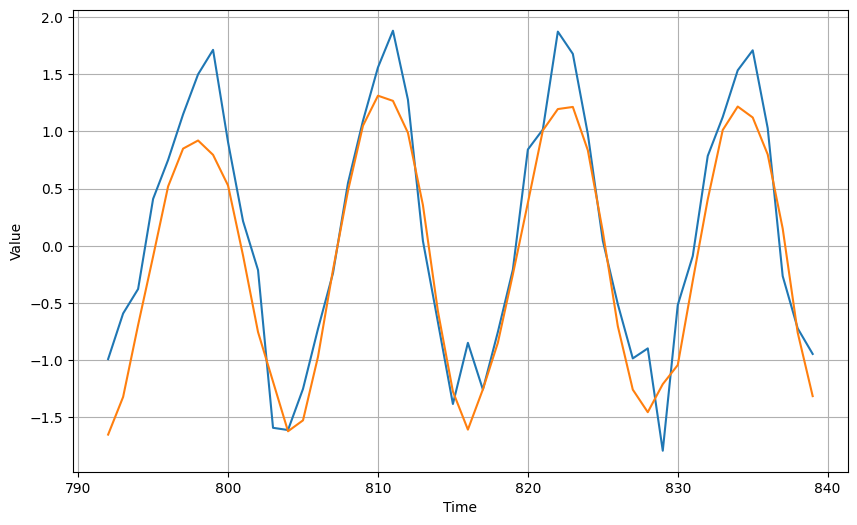

In [44]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.32751253

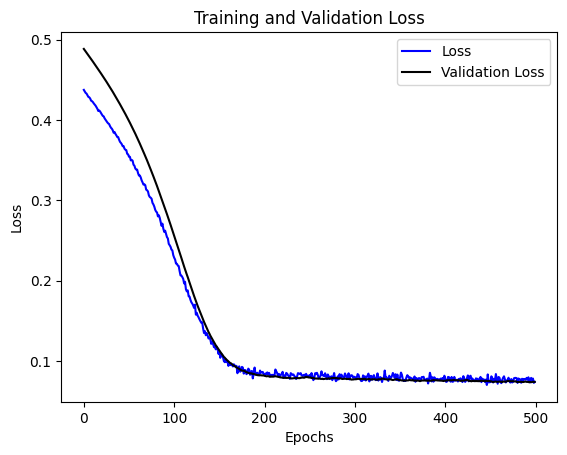

In [46]:
loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

## 양방향 RNN 사용하기

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
64/64 [==============================] - 25s 268ms/step - loss: 0.4307 - mae: 0.8381 - val_loss: 0.4729 - val_mae: 0.8931
Epoch 2/500
64/64 [==============================] - 16s 257ms/step - loss: 0.4209 - mae: 0.8270 - val_loss: 0.4632 - val_mae: 0.8821
Epoch 3/500
64/64 [==============================] - 17s 263ms/step - loss: 0.4127 - mae: 0.8172 - val_loss: 0.4537 - val_mae: 0.8713
Epoch 4/500
64/64 [==============================] - 16s 256ms/step - loss: 0.4044 - mae: 0.8076 - val_loss: 0.4443 - val_mae: 0.8604
Epoch 5/500
64/64 [==============================] - 16s 258ms/step - loss: 0.3962 - mae: 0.7977 - val_loss: 0.4350 - val_mae: 0.8496
Epoch 6/500
64/64 [==============================] - 16s 256ms/step - loss: 0.3876 - mae: 0.7872 - val_loss: 0.4257 - val_mae: 0.8388
Epoch 7/500
64/64 [==============================] - 17s 263ms/step - loss: 0.3799 - mae: 0.7781 - val_loss: 0.4166 - val_mae: 0.8281
Epoch 8/500
64/64 [==============================] - 16s 255ms

In [48]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 68ms/step


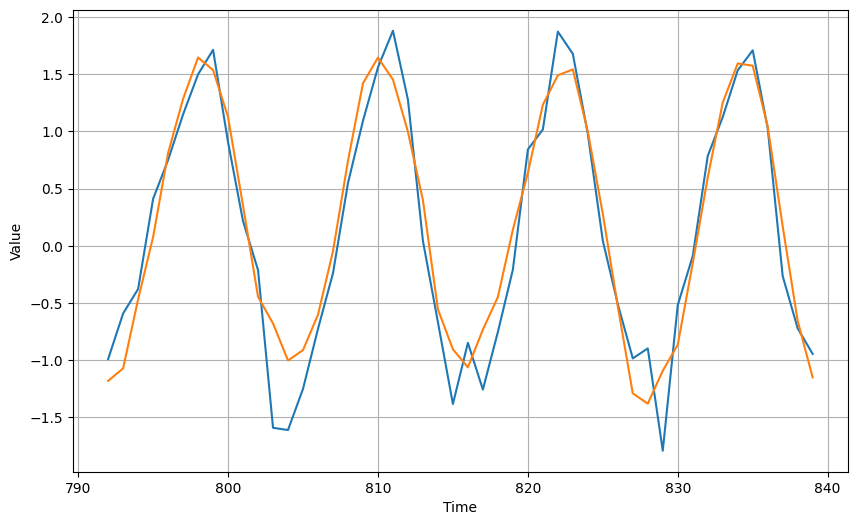

In [49]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [50]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2576672

윈도우 크기 늘려 보기

In [51]:
window_size = 40
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, 
                                 batch_size, shuffle_buffer_size)

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, input_shape=[None, 1],return_sequences=True, 
                            dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1, validation_data=valid_dataset)

Epoch 1/500
63/63 [==============================] - 35s 429ms/step - loss: 0.4349 - mae: 0.8419 - val_loss: 0.5385 - val_mae: 1.0061
Epoch 2/500
63/63 [==============================] - 27s 423ms/step - loss: 0.4311 - mae: 0.8368 - val_loss: 0.5345 - val_mae: 1.0028
Epoch 3/500
63/63 [==============================] - 26s 416ms/step - loss: 0.4258 - mae: 0.8309 - val_loss: 0.5304 - val_mae: 0.9992
Epoch 4/500
63/63 [==============================] - 26s 415ms/step - loss: 0.4216 - mae: 0.8258 - val_loss: 0.5265 - val_mae: 0.9959
Epoch 5/500
63/63 [==============================] - 27s 422ms/step - loss: 0.4186 - mae: 0.8216 - val_loss: 0.5224 - val_mae: 0.9922
Epoch 6/500
63/63 [==============================] - 26s 415ms/step - loss: 0.4135 - mae: 0.8163 - val_loss: 0.5185 - val_mae: 0.9887
Epoch 7/500
63/63 [==============================] - 27s 421ms/step - loss: 0.4096 - mae: 0.8111 - val_loss: 0.5145 - val_mae: 0.9850
Epoch 8/500
63/63 [==============================] - 26s 416ms

In [53]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 69ms/step


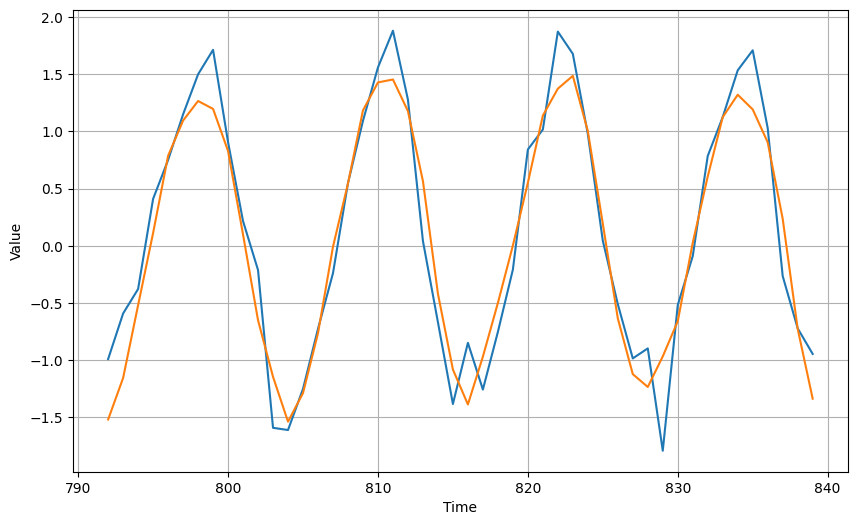

In [54]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [55]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

0.2464757